# Assignment 4. Neural Network with Autograd

Yizhi Zhou | 1003002396 | Mar 23, 2019

In [10]:
%matplotlib inline
import autograd.numpy as np
from autograd import value_and_grad
import matplotlib.pyplot as plt
import math
from data_utils import load_dataset, plot_digit

np.random.seed(0)

BATCHSIZE = 250
ITERCAP = 8000
ERRORBOUND = 0.0002

_COLORS = ['#d6616b', '#fdae6b', '#e7ba52', '#e69fa5', '#dbdb8d']

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
print(x_train[0])

[-0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0.42370354
 -0.42370354 -0.42370354 -0.42370354 -0.42370354 -0

## Neural Network Construction

———————————————————————————————————————————————————————————————————————————————————————————————————————————————
__forward_pass__ computes the forward pass of a two layer neural network. 

The output layer activation function is a __log-softmax activation function__, so that the 10 outputs are class-conditional probabilities of the 10 classes for the mnist_small dataset.
_Note: Ensure that the implementation is numerically stable.__

In [2]:
def forward_pass(W1, W2, W3, b1, b2, b3, x):
    """
    forward-pass for an fully connected neural network with 2 hidden layers of M neurons
    Inputs:
        W1 : (M, 784) weights of first (hidden) layer
        W2 : (M, M) weights of second (hidden) layer
        W3 : (10, M) weights of third (output) layer
        b1 : (M, 1) biases of first (hidden) layer
        b2 : (M, 1) biases of second (hidden) layer
        b3 : (10, 1) biases of third (output) layer
        x : (N, 784) training inputs
    Outputs:
        Fhat : (N, 10) output of the neural network at training inputs
    """
    H1 = np.maximum(0, np.dot(x, W1.T) + b1.T) # layer 1 neurons with ReLU activation, shape (N, M)
    H2 = np.maximum(0, np.dot(H1, W2.T) + b2.T) # layer 2 neurons with ReLU activation, shape (N, M)
    Fhat = np.dot(H2, W3.T) + b3.T # layer 3 (output) neurons with linear activation, shape (N, 10)
    return softmax(Fhat)

In [3]:
def softmax(F):
    """
    Inputs:
        Fhat : (N, 10) output of the neural network at training inputs
    Outputs:
        Phat : (N, 10) from Fhat squashed it to values between zero and one, where each vector sums to one
    """
    # stabalization by shifting the values of each vector in F so that the highest number is 0
    # F -= np.matrix(np.max(F, axis=1)).T
    F -= np.array([list(np.max(F, axis=1))]).T
    Sum = np.sum(np.exp(F), axis=1)
    # P = np.exp(F) / np.matrix(Sum).T
    P = np.log(np.exp(F) / np.array([Sum]).T)
    return P

———————————————————————————————————————————————————————————————————————————————————————————————————————————————
__negative_log_likelihood__ computes the negative log-likelihood of the neural network defined in the forward_pass. In other words, it returns a scalar for a mini-batch of inputs assuming that the outputs of forward_pass are __class-conditional log probabilities__. 

In [4]:
def negative_log_likelihood(W1, W2, W3, b1, b2, b3, x, y):
    """
    computes the negative log likelihood of the model `forward_pass`
         using categorical (generalized Bernoulli) likelihood
    Inputs:
        W1, W2, W3, b1, b2, b3, x : same as `forward_pass`
        y : (N, 10) training responses
    Outputs:
        nll : negative log likelihood
    """
    Fhat = forward_pass(W1, W2, W3, b1, b2, b3, x)
    nll = -np.sum(np.sum(np.multiply(y,Fhat), axis=1))
    # print('\n nll:', nll)
    return nll/x.shape[0]

———————————————————————————————————————————————————————————————————————————————————————————————————————————————
__nll_gradients__ returns the __negative log-likelihood__ computed by negative_log_likelihood, as well as the __gradients__ of this value with respect to all weights and biases in the neural network. _(No need to modify.)_

In [5]:
nll_gradients = value_and_grad(negative_log_likelihood, argnum=[0,1,2,3,4,5])
"""
    returns the output of `negative_log_likelihood` as well as the gradient of the 
    output with respect to all weights and biases
    Inputs:
        same as negative_log_likelihood (W1, W2, W3, b1, b2, b3, x, y)
    Outputs: (nll, (W1_grad, W2_grad, W3_grad, b1_grad, b2_grad, b3_grad))
        nll : output of `negative_log_likelihood`
        W1_grad : (M, 784) gradient of the nll with respect to the weights of first (hidden) layer
        W2_grad : (M, M) gradient of the nll with respect to the weights of second (hidden) layer
        W3_grad : (10, M) gradient of the nll with respect to the weights of third (output) layer
        b1_grad : (M, 1) gradient of the nll with respect to the biases of first (hidden) layer
        b2_grad : (M, 1) gradient of the nll with respect to the biases of second (hidden) layer
        b3_grad : (10, 1) gradient of the nll with respect to the biases of third (output) layer
     """

'\n    returns the output of `negative_log_likelihood` as well as the gradient of the \n    output with respect to all weights and biases\n    Inputs:\n        same as negative_log_likelihood (W1, W2, W3, b1, b2, b3, x, y)\n    Outputs: (nll, (W1_grad, W2_grad, W3_grad, b1_grad, b2_grad, b3_grad))\n        nll : output of `negative_log_likelihood`\n        W1_grad : (M, 784) gradient of the nll with respect to the weights of first (hidden) layer\n        W2_grad : (M, M) gradient of the nll with respect to the weights of second (hidden) layer\n        W3_grad : (10, M) gradient of the nll with respect to the weights of third (output) layer\n        b1_grad : (M, 1) gradient of the nll with respect to the biases of first (hidden) layer\n        b2_grad : (M, 1) gradient of the nll with respect to the biases of second (hidden) layer\n        b3_grad : (10, 1) gradient of the nll with respect to the biases of third (output) layer\n     '

## Visualization of the MNIST_small dataset
Just for fun ;)

In [6]:
def get_classes(Y):
    """
    Inputs:
        y : (N, 10) 
    Outputs:
        y : (N,) squeezing into one class of each vector, which has the highest log likelihood
    """
    return np.argmax(Y, axis=1)

def get_class(y):
    """
    Inputs:
        y : (10,) in the form of [False False False False True False False False False False]
                usually fetched by y_train[n]
    Outputs:
        An integer from 0 to 9 indicating the index that is "True", namely the predicted/labeled number
        ** To see the number, the result needs to be printed **
    """
    return np.argmax(y)

def get_image(x):
    """
    Inputs:
        x : (784,) a datapoint's features that can be composed into a 28*28 matrix of grey scale image
    Outputs:
        The image
    """
    x = x.reshape(28,28)
    plt.imshow(x, cmap='Greys')

In [7]:
def show_images(indices, x_set, y_set, y_pred=np.array([]), rows=0, weights=False):
    """
    Inputs:
        x_set, y_set : (N, 784) and (N, 10) datasets and their labels, can be training or validation/testing ones
        indices : a list of indices correspinding to the datapoints of interest
        test : boolean variable specifying if it is the train set or test set
        cols : a positive integer, specifying the number of columns wanted in the output figure
    Outputs:
        A matrix of figures, corresponding to the specified datapoints
    """
    n = len(indices)
    if n == 0: 
        print('Congrats! There \'s no false prediction.')
        return
    if rows == 0: rows=np.ceil(n/15)
    fig = plt.figure()
    for i, index in enumerate(indices):
        ax = fig.add_subplot(rows, np.ceil(n/rows), i + 1)
        get_image(x_set[index])
        if not weights:
            if y_pred.size == 0: ## Then it is the train set
                ax.set_title('Label: %d'%(get_class(y_set[index])))
            else: ## Validation or testing
                ax.set_title('Label: %d, Prediction: %d'%(get_class(y_set[index]), get_class(y_pred[index])))
        else:
            ax.set_title('Weight No.%d'%(y_set[index]))
    currsize = fig.get_size_inches()
    width, height = currsize[0] * np.ceil(n/rows) * 0.5, currsize[1] * rows * 0.8 
    fig.set_size_inches(width, height)
    plt.show()

## Neural Network Configuration and Training
__TrainMnist__ loads the Mnist dataset, initializes the parameters, runs the gradient descent, and compares the predictions to the labels. It can be seen as the main body of the neural network.

In [8]:
class TrainMnist:
    def __init__(self):
        self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test  = load_dataset('mnist_small')
        self.num_train, self.num_valid = self.x_train.shape[0], self.x_valid.shape[0]
        self.indices = list(range(self.num_train))
        np.random.seed(0)
        np.random.shuffle(self.indices)
        self.x_train_Random, self.y_train_Random = self.x_train[self.indices], self.y_train[self.indices]
        
        self.indicesValidation = list(range(self.num_valid))
        np.random.seed(0)
        np.random.shuffle(self.indicesValidation)
        self.x_valid_Random, self.y_valid_Random = self.x_valid[self.indicesValidation], self.y_valid[self.indicesValidation]
        
        self.colorIndex = 0
        
    def set_parameters(self, M=BATCHSIZE, learningRate=0.01):
        """
        Inputs:
            M : number of neurons per hidden layer (eg. 10, 100, 200)

        """
        self.M = M # 50 neurons per hidden layer
        self.lr = learningRate

        # initialize the weights and biases of the fully-connected 2-layer network
        self.W1 = np.random.randn(M, 784) / np.sqrt(784) # weights of first (hidden) layer
        self.W2 = np.random.randn(M, M) / np.sqrt(M) # weights of second (hidden) layer
        self.W3 = np.random.randn(10, M) / np.sqrt(M) # weights of third (output) layer
        self.b1 = np.zeros((M, 1)) # biases of first (hidden) layer
        self.b2 = np.zeros((M, 1)) # biases of second (hidden) layer
        self.b3 = np.zeros((10, 1)) # biases of third (output) layer
        
    def update_parameters(self, w, grad_w):
        """
        perform gradient descent update to minimize an objective
        Inputs:
            w : vector of parameters
            grad_w : gradient of the loss with respect to the parameters
        """
        return w - self.lr * grad_w
        
    def run_SGD(self, trace=False, plot=False, validation=False):
        i, ROUND, LOSS, stablized, minLoss = 0, [], [], 0, float('inf')
        if validation: LOSSValidation = []
        while i < ITERCAP and stablized < 1:
            for j in range(0, self.num_train, BATCHSIZE):
                i += 1
                X, Y = self.x_train_Random[j:j+BATCHSIZE], self.y_train_Random[j:j+BATCHSIZE]
                # compute the gradient            
                (nll, (W1_grad, W2_grad, W3_grad, b1_grad, b2_grad, b3_grad)) = \
                nll_gradients(self.W1, self.W2, self.W3, self.b1, self.b2, self.b3, X, Y)
                # update the parameters
                self.W1 = self.update_parameters(self.W1, W1_grad)
                self.W2 = self.update_parameters(self.W2, W2_grad)
                self.W3 = self.update_parameters(self.W3, W3_grad)
                self.b1 = self.update_parameters(self.b1, b1_grad)
                self.b2 = self.update_parameters(self.b2, b2_grad)
                self.b3 = self.update_parameters(self.b3, b3_grad)
                # record loss and print if nessessary
                if i==1 or (i) % 1 == 0:
                    ROUND.append(i)
                    LOSS.append(nll)
                    if validation:
                        jj = int(np.floor(j/13))
                        X, Y = self.x_valid_Random[jj:jj+BATCHSIZE], self.y_valid_Random[jj:jj+BATCHSIZE]
                        LOSSValidation.append(negative_log_likelihood(self.W1, self.W2, self.W3, self.b1, self.b2, self.b3, X, Y))
                    if trace:
                        print("Iter %5d, Negative log likelihood: = %.5f" % (i, nll))
                        # print('Fhat:\n', forward_pass(self.W1, self.W2, self.W3, self.b1, self.b2, self.b3, self.x_train[:num]))

                    #Convergence conditions
                    try:
                        error = abs(LOSS[-1] - LOSS[-2])
                    except:
                        error = float('inf')
                    if nll > minLoss:
                        stablized += 0.1/20
                        if trace: print('minLoss:', minLoss, 'stablized:', stablized)
                    else: 
                        if error <= ERRORBOUND or abs(nll-minLoss) <= ERRORBOUND:
                            stablized += 0.5/20
                            if trace: print('stablized:', stablized)
                        minLoss = nll
                            
                if stablized >= 1 or i >= ITERCAP:
                    if trace: 
                        print('Converged!')
                        print('Error:', error)
                    break
            
        # print("Negative log likelihood: %.5f" % nll)
        if plot:
            plt.style.use('bmh')
            label =  '%3d unit & learning rate %.3f: nll = %.3f @ %d iters'%(self.M, self.lr, LOSS[-1], ROUND[-1])
            
            if validation:
                labelValidation = 'Validation set, nll = %.4f @ %d iterations'%(LOSSValidation[-1], ROUND[-1])
                plt.plot(ROUND, LOSSValidation, label=labelValidation, linewidth=1, color=_COLORS[self.colorIndex%5+3])
                label = 'Training set, nll = %.4f @ %d iterations'%(LOSS[-1], ROUND[-1])
            
            plt.plot(ROUND, LOSS, label=label, linewidth=1, color=_COLORS[self.colorIndex%5])
            plt.legend()
            plt.title('Negative Log Probability vs. Gradient Descent Iteration', loc='center', size=12)
            self.colorIndex += 1
            # plt.show()
        
        return self.W1, self.W2, self.W3, self.b1, self.b2, self.b3
    
    def get_prediction(self, set='test', mistakes=False, inconfident=False, num=0):
        if set == 'train':
            if num == 0: X, Y_label = self.x_train, self.y_train
            else: X, Y_label = self.x_train[:num], self.y_train[:num]
        elif set == 'validation':
            X, Y_label = self.x_valid, self.y_valid
        elif set == 'test':
            X, Y_label = self.x_test, self.y_test
        
        Y_pred = forward_pass(self.W1, self.W2, self.W3, self.b1, self.b2, self.b3, X)
        predictions = get_classes(Y_pred)
        labels = get_classes(Y_label)
        # print('Predictions:', predictions, 'Labels:', labels)
        accuracy = sum(predictions==labels)/labels.size
        print("Accuracy over the %s set: %.3f %%" % (set, accuracy*100))
        nll = negative_log_likelihood(self.W1, self.W2, self.W3, self.b1, self.b2, self.b3, X, Y_label)
        print("Negative log likelihood over the %s set: %.3f" % (set, nll))
        
        if inconfident:
            inconfident_indices = [i for i in range(len(predictions)) if Y_pred[i][predictions[i]] < -0.7]
            print('Inconfident ones:')
            # print(inconfident_indices)
            show_images(inconfident_indices, X, Y_label, Y_pred)
            
        if mistakes:
            mistake_indices = [i for i in range(len(predictions)) if predictions[i]!=labels[i]]
            print('Wrong ones:')
            show_images(mistake_indices, X, Y_label, Y_pred)

## NN's performance on Training vs. Validation sets

With 100 neurons per layer, the followings are plotted (in the same figure):
* the stochastic estimate of the __training__ set negative log-likelihood vs. iteration number
* that of the __validation__ set negative log-likelihood vs. iteration number. 

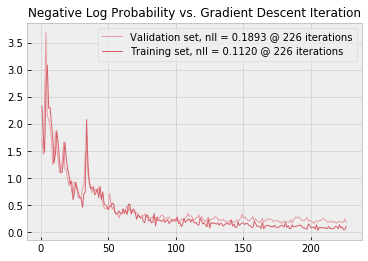

In [17]:
M = 100
NN = TrainMnist()
NN.set_parameters(M=M, learningRate=0.5)
W1, W2, W3, b1, b2, b3 = NN.run_SGD(trace=False, plot=True, validation=True)
plt.show()

## NN's performance using different constructions

Test the performance with 10, 100, or 200 hidden units per layer of the fully connected network. Specifically, compare the __validation set negative log-likelihood__ and the __validation set accuracy__ of each configuration. For the best architecture, report the test set negative log-likelihood and test set accuracy.

Note that the learning rate and the number of iterations might need to be adjusted. 

Accuracy over the validation set: 88.800 %
Negative log likelihood over the validation set: 0.381
Accuracy over the validation set: 92.800 %
Negative log likelihood over the validation set: 0.209
Accuracy over the validation set: 94.500 %
Negative log likelihood over the validation set: 0.170


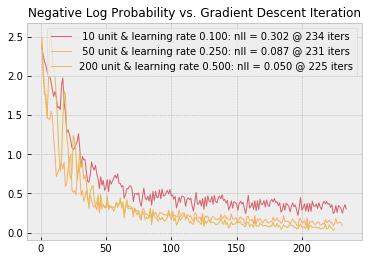

In [23]:
NN = TrainMnist()

# Configuration No.1
NN.set_parameters(M=10, learningRate = 0.1)
NN.W1, NN.W2, NN.W3, NN.b1, NN.b2, NN.b3 = NN.run_SGD(trace=False, plot=True)
NN.get_prediction(set='validation', mistakes=False, inconfident=False)

# Configuration No.2
NN.set_parameters(M=50, learningRate = 0.25)
NN.W1, NN.W2, NN.W3, NN.b1, NN.b2, NN.b3 = NN.run_SGD(trace=False, plot=True)
NN.get_prediction(set='validation', mistakes=False, inconfident=False)

# Configuration No.3
NN.set_parameters(M=200, learningRate = 0.5)
NN.W1, NN.W2, NN.W3, NN.b1, NN.b2, NN.b3 = NN.run_SGD(trace=False, plot=True)
NN.get_prediction(set='validation', mistakes=False, inconfident=False)

plt.show()

In [22]:
# Best Configuration from the above
NN = TrainMnist()
NN.set_parameters(M=200, learningRate = 0.5)
NN.W1, NN.W2, NN.W3, NN.b1, NN.b2, NN.b3 = NN.run_SGD(trace=False, plot=False)
NN.get_prediction(set='test', mistakes=False, inconfident=False, num=0)

Accuracy over the test set: 96.100 %
Negative log likelihood over the test set: 0.129


# Neuron Visualization
With the configuration of 100 neurons per hidden layer, visualize the first layer weights of 16 neurons in the fully connected neural network, each as an image.

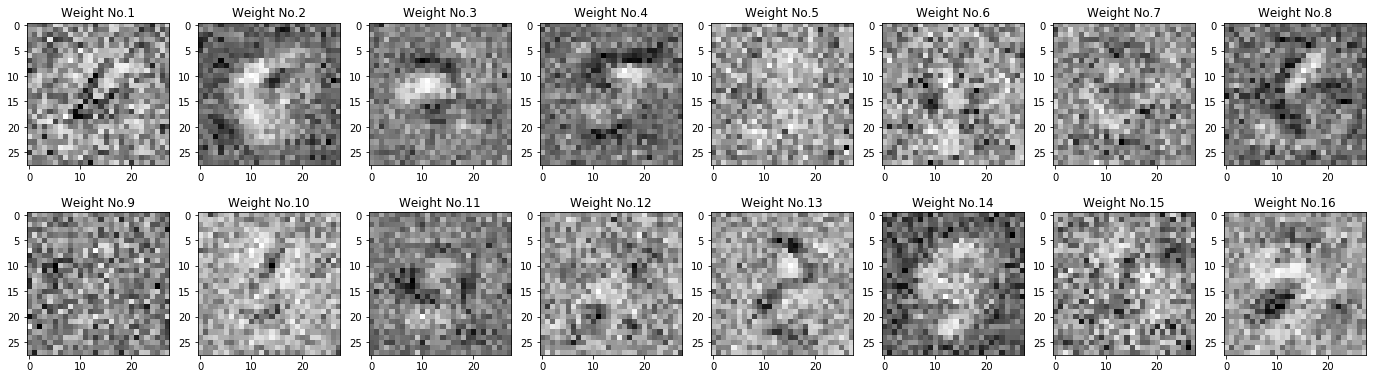

[ 2.73812988e-02 -7.20094051e-03 -2.39597343e-02  3.92824204e-02
  9.02343625e-02  4.23955600e-02  3.89618424e-02  3.85540189e-02
  4.89778981e-02  2.19506998e-02  9.10369624e-03  6.13902912e-02
 -2.88927167e-02  8.59586919e-02  2.00427519e-02 -6.32215773e-03
  3.07739264e-02  7.13567941e-02 -2.96990484e-02  7.23669168e-02
  3.75115900e-02 -1.68814460e-02  4.85923786e-02  3.02030311e-02
  2.58947390e-02  3.10555535e-02  1.49943740e-02 -1.34154565e-02
 -4.16803183e-02  9.25373492e-03 -3.54266707e-02  3.21839313e-03
  7.43517715e-03  2.89676091e-02 -1.19486691e-02  3.82779663e-02
  2.91166647e-02  3.19982468e-02  5.99587533e-02 -1.66251703e-04
  3.73846297e-02  3.85625187e-03 -4.67256177e-02  8.85002431e-02
  1.26318949e-01  1.11244902e-01  1.71156580e-02 -5.20432303e-02
  9.44768030e-02  1.40519913e-02 -5.49355240e-02  3.18267802e-02
  4.86191840e-02 -1.88431332e-02  5.81145354e-02 -1.31165028e-02
  5.18810706e-02  6.99911778e-02  8.45298295e-02  2.62692682e-04
 -6.74954618e-03 -1.01478

In [9]:
NN = TrainMnist()
NN.set_parameters(M=100, learningRate = 0.5)
NN.W1, NN.W2, NN.W3, NN.b1, NN.b2, NN.b3 = NN.run_SGD(trace=False, plot=False)
show_images(list(range(16)), NN.W1, list(range(1, 17)), weights=True)
print(NN.W1[1])

## Inconfident and wrong predictions
A few test set digits where the neural network is not confident of the classifica- tion output (i.e. the top class conditional probability is below some threshold).

Accuracy over the test set: 96.100 %
Negative log likelihood over the test set: 0.129
Inconfident ones:


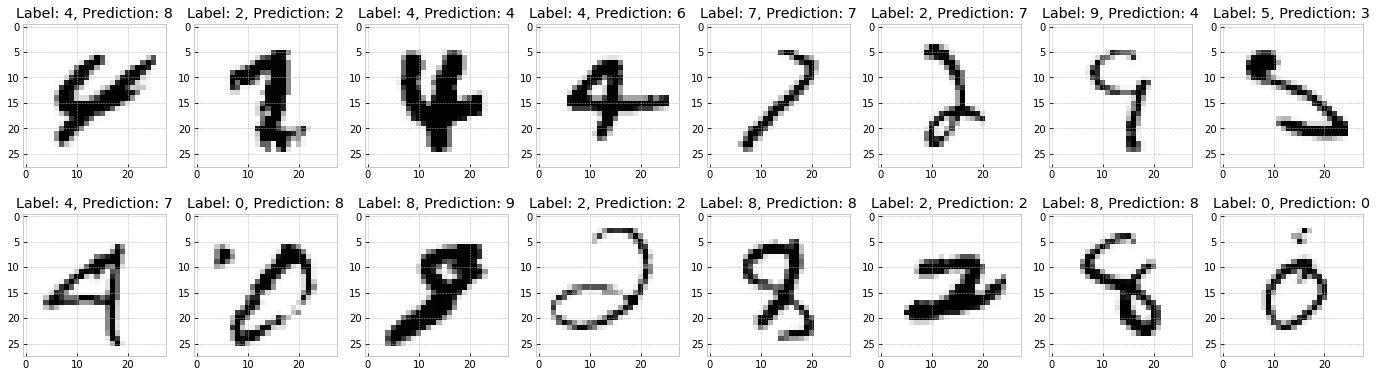

Wrong ones:


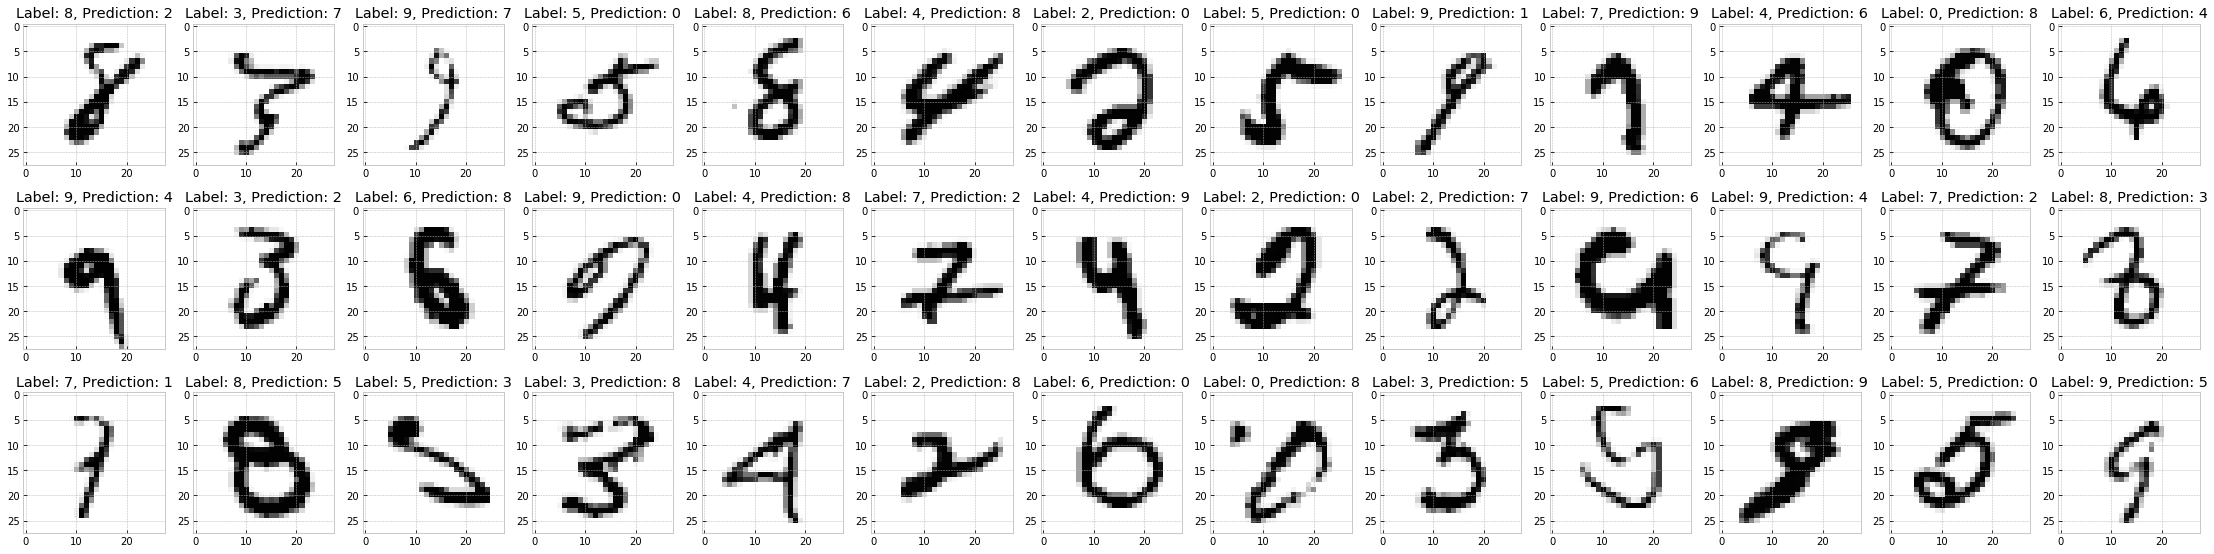

In [24]:
NN = TrainMnist()
NN.set_parameters(M=200, learningRate = 0.5)
NN.W1, NN.W2, NN.W3, NN.b1, NN.b2, NN.b3 = NN.run_SGD(trace=False, plot=False)
NN.get_prediction(set='test', mistakes=True, inconfident=True)